In [4]:
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns
import torch

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
# Render the figure in a notebook:
%matplotlib inline  

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import plot_tree

from sklearn import metrics

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.nn.functional as F

from torchmetrics.classification import Accuracy
from torchmetrics.classification import Recall
from torchmetrics import R2Score
from torchmetrics import MeanAbsoluteError

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [5]:
x_train = pd.read_csv('../no_nontoxic_nans_X_train.csv', index_col=0)
y_train = pd.read_csv('../no_nontoxic_nans_y_train.csv', index_col=0)

x_val = pd.read_csv('../no_nontoxic_nans_X_val.csv', index_col=0)
y_val = pd.read_csv('../no_nontoxic_nans_y_val.csv', index_col=0)

x_test = pd.read_csv('../no_nontoxic_nans_x_test.csv', index_col=0)
y_test = pd.read_csv('../no_nontoxic_nans_y_test.csv', index_col=0)


In [6]:
RFC = RandomForestClassifier(n_estimators=100, criterion='gini')
RFC_model = RFC.fit(x_train,y_train)

def model_metrics(x_data, y_data, model):
    model_prediction = model.predict(x_data)
    accuracy_prediciton = metrics.accuracy_score(y_data, model_prediction)
    print('accuracy:', accuracy_prediciton)


c:\Users\dx21006\.conda\envs\chem-ml-env\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [7]:
model_metrics(x_train, y_train, RFC_model)
model_metrics(x_val, y_val, RFC_model)
model_metrics(x_test, y_test, RFC_model)

accuracy: 0.9989162828501761
accuracy: 0.773989898989899
accuracy: 0.7853535353535354


In [8]:
def get_confusion_matrix(x_data, y_data, model, train_test_val_type):
    model_prediction = model.predict(x_data)
    ConfusionMatrixDisplay.from_predictions(y_data, model_prediction)
    plt.title('Confusion Matrix for {:} data'.format(train_test_val_type));

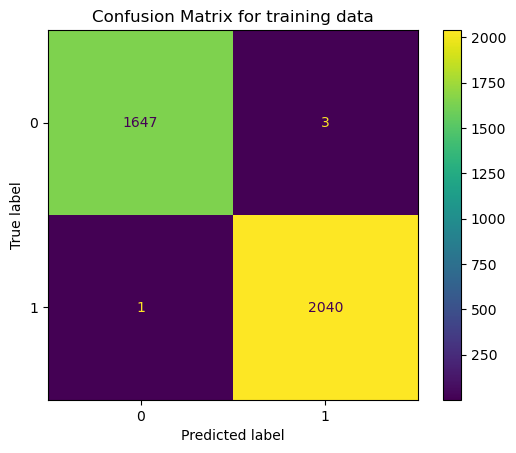

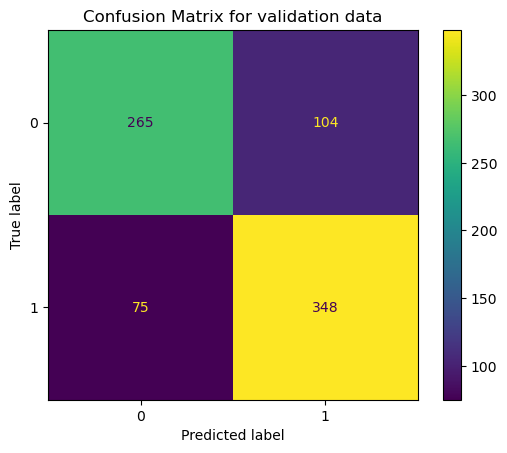

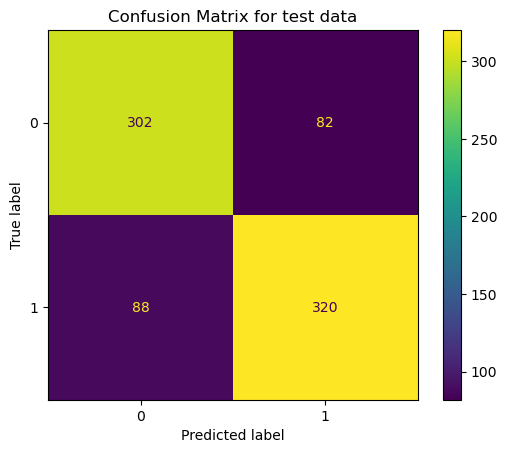

In [9]:
get_confusion_matrix(x_train, y_train, RFC_model, 'training') 
get_confusion_matrix(x_val, y_val, RFC_model, 'validation') 
get_confusion_matrix(x_test, y_test, RFC_model, 'test') 

# Hyperparameter Tuning

In [10]:
np.linspace(2, 10, 5, dtype=int)

array([ 2,  4,  6,  8, 10])

In [11]:
y_train_array = y_train.to_numpy().flatten()
y_train_array


array([0, 0, 1, ..., 0, 1, 1], shape=(3691,))

In [13]:
#parameters
random_search_params = {
    'n_estimators' : np.linspace(10, 500, 10, dtype=int),
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_depth' : np.linspace(1, 50, 10, dtype=int),
    'min_samples_split' : np.linspace(2, 10, 5, dtype=int),
    'min_samples_leaf' : np.linspace(1, 10, 5, dtype=int),
    'max_features' : ['sqrt', 'log2']
}

random_search_RFC = RandomForestClassifier(random_state=0)
random_search = RandomizedSearchCV(estimator=random_search_RFC, param_distributions=random_search_params, n_iter=50, cv=5, verbose=2, scoring='balanced_accuracy')
random_search.fit(x_train, y_train_array)
best_RF = random_search.best_estimator_ # Get the best estimator from the grid search
y_pred = best_RF.predict(x_test)
bacc = metrics.balanced_accuracy_score(y_test, y_pred)
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")
print(f"bacc: {bacc}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import  GridSearchCV

In [ ]:
# grid search optimisation
grid_search_params = {
    'n_estimators' : np.linspace(450, 550, 5, dtype=int),
    'criterion' : ['gini'],
    'max_depth' : np.linspace(22, 32, 5, dtype=int),
    'min_samples_split' : [3,4,5],
    'min_samples_leaf' : [1,2],
    'max_features' : ['log2']
}

grid_search_RFC = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(estimator=grid_search_RFC, param_grid=grid_search_params, cv=5, n_jobs=-1, verbose=2, scoring='balanced_accuracy')
grid_search.fit(x_train, y_train_array)
best_RF_grid = grid_search.best_estimator_ # Get the best estimator from the grid search
y_pred = best_RF_grid.predict(x_test)
bacc = metrics.balanced_accuracy_score(y_test, y_pred)
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")
print(f"bacc: {bacc}")

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best parameters: {'criterion': 'gini', 'max_depth': np.int64(27), 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': np.int64(450)}
bacc: 0.8030024509803921


In [ ]:
best_RF_grid

NameError: name 'best_RF_grid' is not defined

In [ ]:
#should be looking at val stats not test stats!!!
y_pred_train = best_RF_grid.predict(x_train)
y_pred_val = best_RF_grid.predict(x_val)
bacc_train = metrics.balanced_accuracy_score(y_train, y_pred_train)
bacc_val = metrics.balanced_accuracy_score(y_val, y_pred_val)
print(f"bacc train: {bacc_train}")
print(f"bacc val: {bacc_val}")

bacc train: 0.9942168871468234
bacc val: 0.7870034019489132


c:\Users\dx21006\.conda\envs\chem-ml-env\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


accuracy: 0.9937686263885126
accuracy: 0.7752525252525253


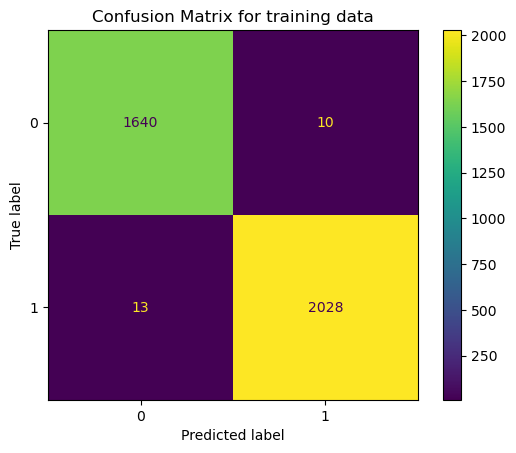

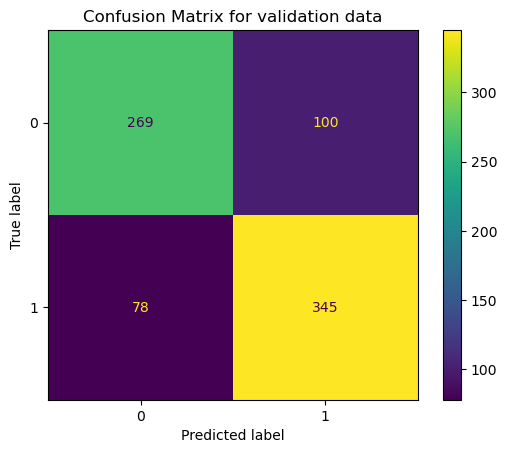

In [14]:
RFC_optimised = RandomForestClassifier(n_estimators=450, criterion='gini', max_depth=27, min_samples_split=5, min_samples_leaf=1, max_features='log2')
RFC_optimised_model = RFC_optimised.fit(x_train,y_train)
y_pred_val = RFC_optimised_model.predict(x_val)
model_metrics(x_train, y_train, RFC_optimised_model)
model_metrics(x_val, y_val, RFC_optimised_model)

get_confusion_matrix(x_train, y_train, RFC_optimised_model, 'training') 
get_confusion_matrix(x_val, y_val, RFC_optimised_model, 'validation') 

In [15]:
from sklearn import metrics
def get_model_metrics(fitted_model, x_train, x_val, y_train, y_val):
    pred_X_train = fitted_model.predict(x_train)
    pred_X_val = fitted_model.predict(x_val)
    train_bal_acc = metrics.balanced_accuracy_score(y_train, pred_X_train)
    val_bal_acc = metrics.balanced_accuracy_score(y_val, pred_X_val)
    train_recall = metrics.recall_score(y_train, pred_X_train)
    val_recall = metrics.recall_score(y_val, pred_X_val)
    train_precision = metrics.precision_score(y_train, pred_X_train)
    val_precision = metrics.precision_score(y_val, pred_X_val)
    train_f1 = metrics.f1_score(y_train, pred_X_train)
    val_f1 = metrics.f1_score(y_val, pred_X_val)
    metric_list = [train_bal_acc, train_recall, train_precision, train_f1, val_bal_acc, val_recall, val_precision, val_f1]
    print(metric_list)
get_model_metrics(RFC_optimised_model, x_train, x_val, y_train, y_val)

[0.9937849835939008, 0.9936305732484076, 0.9950932286555446, 0.9943613630791861, 0.7723000634261661, 0.8156028368794326, 0.7752808988764045, 0.7949308755760369]


# Feature Importance Experiment
By Matt. Try and get some interesting histograms out of this?? Using this model because my NN one is shite.
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [ ]:
#This is impurity based feature importance, apparently this is bad, using permutation based instead below
RFC_importances_impurity = pd.DataFrame(RFC_optimised_model.feature_importances_)
RFC_importances_impurity['feature'] = x_train.columns
RFC_importances_impurity

,0,feature
0,0.008743,MaxAbsEStateIndex
1,0.009301,MaxEStateIndex
2,0.008493,MinAbsEStateIndex
3,0.008660,MinEStateIndex
4,0.009297,qed
...,...,...
212,0.000121,fr_thiazole
213,0.000053,fr_thiocyan
214,0.000156,fr_thiophene
215,0.001439,fr_unbrch_alkane


In [ ]:
from sklearn.inspection import permutation_importance
import time

start_time = time.time()
RFC_importances_permutation = RFC_optimised_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in RFC_optimised_model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
RFC_importances_permutation = pd.DataFrame(RFC_importances_permutation)
RFC_importances_permutation['feature'] = x_train.columns
RFC_importances_permutation

Elapsed time to compute the importances: 0.021 seconds


,0,feature
0,0.008743,MaxAbsEStateIndex
1,0.009301,MaxEStateIndex
2,0.008493,MinAbsEStateIndex
3,0.008660,MinEStateIndex
4,0.009297,qed
...,...,...
212,0.000121,fr_thiazole
213,0.000053,fr_thiocyan
214,0.000156,fr_thiophene
215,0.001439,fr_unbrch_alkane


our top 10 most important features according to permutation

In [ ]:
def get_feature_importance(model_fitted, top_n=10, df_x_train=x_train): #need to provide a fitted model, top_n = top n features to return sorted by toxicity (default 10), df_x_train = the name of your x_train dataframe (for naming reasons). defaults to x_train
    """Returns the feature importances as a dataframe"""
    importances_permutation = model_fitted.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model_fitted.estimators_], axis=0)
    df_importances_permutation = pd.DataFrame(importances_permutation)
    df_importances_permutation['feature'] = df_x_train.columns

    df_top_n_importances_permutation = df_importances_permutation.nlargest(top_n, 0)
    print(df_top_n_importances_permutation)

    df_importances_permutation_FG = df_importances_permutation[df_importances_permutation['feature'].str.contains("fr_")] #new df containing only the features called fr_, i.e. the functional groups
    df_importances_permutation_FG_top_10 = df_importances_permutation_FG.nlargest(top_n,0)
    print(df_importances_permutation_FG_top_10)


            0         feature
130  0.023504         MolLogP
6    0.021715           MolWt
28   0.019562         BertzCT
7    0.018971  HeavyAtomMolWt
22   0.018532   BCUT2D_LOGPHI
8    0.016199      ExactMolWt
68   0.015958        SMR_VSA7
131  0.015147           MolMR
46   0.014768       LabuteASA
79   0.014493      SlogP_VSA6
            0                 feature
166  0.006020              fr_benzene
168  0.003558             fr_bicyclic
197  0.002643               fr_phenol
198  0.002621  fr_phenol_noOrthoHbond
161  0.002364              fr_aniline
147  0.002269                  fr_NH0
139  0.001995                fr_Ar_OH
173  0.001952                fr_ether
142  0.001872                  fr_C_O
158  0.001870         fr_allylic_oxid


In [ ]:
top_10_RFC_importances_permutation = RFC_importances_permutation.nlargest(10, 0)
top_10_RFC_importances_permutation

,0,feature
28,0.021521,BertzCT
22,0.020537,BCUT2D_LOGPHI
130,0.019841,MolLogP
131,0.019343,MolMR
6,0.017033,MolWt
7,0.015886,HeavyAtomMolWt
68,0.015507,SMR_VSA7
8,0.015505,ExactMolWt
46,0.015328,LabuteASA
79,0.015144,SlogP_VSA6


In [ ]:
top_10_RFC_importances_impurity = RFC_importances_impurity.nlargest(10,0)
top_10_RFC_importances_impurity

,0,feature
28,0.021521,BertzCT
22,0.020537,BCUT2D_LOGPHI
130,0.019841,MolLogP
131,0.019343,MolMR
6,0.017033,MolWt
7,0.015886,HeavyAtomMolWt
68,0.015507,SMR_VSA7
8,0.015505,ExactMolWt
46,0.015328,LabuteASA
79,0.015144,SlogP_VSA6


A topological index meant to quantify “complexity” of molecules.

interestingly, the data is the same using both feature importance methods. Just use permutatioin because apparently it's better? How can we tell if higher / lower is more toxic

# Finding the worse functional groups

In [ ]:
RFC_importance_perm_FG = RFC_importances_permutation[RFC_importances_permutation['feature'].str.contains("fr_")] #new df containing only the features called fr_, i.e. the functional groups
RFC_importance_perm_FG_top_10 = RFC_importance_perm_FG.nlargest(20,0)
RFC_importance_perm_FG_top_10

,0,feature
166,0.005995,fr_benzene
168,0.003369,fr_bicyclic
198,0.003169,fr_phenol_noOrthoHbond
161,0.002905,fr_aniline
197,0.002374,fr_phenol
142,0.002138,fr_C_O
147,0.002064,fr_NH0
139,0.002053,fr_Ar_OH
173,0.002012,fr_ether
176,0.002010,fr_halogen


is this looking at just the most toxic compounds? Or what contributes most to overall score? ie could include non-toxic ones that lead to a definite non-toxic result

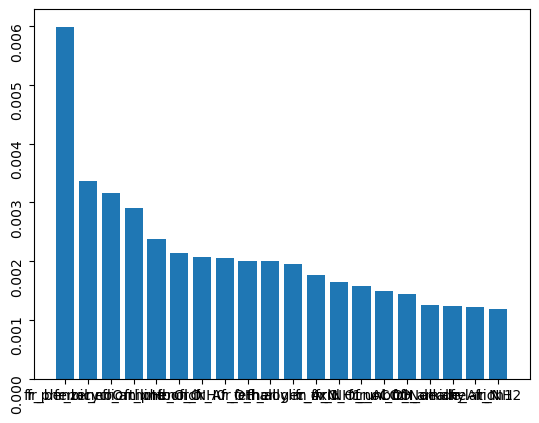

In [ ]:
plt.bar(RFC_importance_perm_FG_top_10['feature'], RFC_importance_perm_FG_top_10[0])
plt.yticks(rotation='vertical')
plt.show()

In [ ]:
get_feature_importance(RFC_optimised_model)

NameError: name 'get_feature_importance' is not defined

     0         feature
     130  0.023504         MolLogP
     6    0.021715           MolWt
     28   0.019562         BertzCT
     7    0.018971  HeavyAtomMolWt
     22   0.018532   BCUT2D_LOGPHI
     8    0.016199      ExactMolWt
     68   0.015958        SMR_VSA7
     131  0.015147           MolMR
     46   0.014768       LabuteASA
     79   0.014493      SlogP_VSA6
               0                 feature
     166  0.006020              fr_benzene
     168  0.003558             fr_bicyclic
     197  0.002643               fr_phenol
     198  0.002621  fr_phenol_noOrthoHbond
     161  0.002364              fr_aniline
     147  0.002269                  fr_NH0
     139  0.001995                fr_Ar_OH
     173  0.001952                fr_ether
     142  0.001872                  fr_C_O
     158  0.001870         fr_allylic_oxid

In [16]:
def return_classifications(fitted_model, y_true, y_predicted): #use y_val and y_predicted
    ## Correct is 0 
    # FP is -1 
    # FN is 1
    # from https://stackoverflow.com/questions/61893001/get-list-of-true-positives-false-positives-false-negatives-and-true-negatives
    diff = y_true-y_predicted
    return diff
df_diff = pd.DataFrame(return_classifications(RFC_optimised_model, np.array(y_val['toxic']),y_pred_val))

In [51]:
x_val_classifications = x_val.reset_index(drop=True)
df_diff.reset_index(drop=True)
x_val_classifications = x_val_classifications.join(df_diff[0])
x_val_classifications.rename(columns={0 :'classification'}, inplace=True)
#rename the 0 column to classification


In [52]:
desc_and_tox = pd.read_csv('../no_nontoxic_nans_desc_and_toxicity.csv',index_col=0)
desc_and_tox

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,smiles,mol_id,toxic
0,11.107593,11.107593,0.073011,-3.723219,0.900283,11.875000,258.324,248.244,258.013284,86.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,TOX3021,1
1,10.251875,10.251875,0.383488,-5.197724,0.365583,15.090909,206.027,197.963,205.974526,68.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CC(O)(P(=O)(O)O)P(=O)(O)O,TOX20800,0
2,10.598302,10.598302,0.135802,-3.530602,0.609724,11.300000,176.624,171.584,175.969878,54.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,O=S(=O)(Cl)c1ccccc1,TOX6619,0
3,10.775986,10.775986,0.010525,-0.858003,0.489304,10.428571,621.934,612.862,621.763503,110.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1,TOX25232,1
4,10.825046,10.825046,0.001157,-0.103056,0.564836,10.600000,144.214,128.086,144.115030,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CC(C)COC(=O)C(C)C,TOX6612,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5270,5.437662,5.437662,0.327913,0.327913,0.856312,17.727273,298.346,280.202,298.142976,114.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,c1cnc(N2CCN(Cc3ccc4c(c3)OCO4)CC2)nc1,TOX25188,0
5271,12.146718,12.146718,0.245103,0.245103,0.701319,49.000000,314.469,284.229,314.224580,126.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(...,TOX2370,1
5272,11.787348,11.787348,0.082288,-0.082288,0.734230,52.714286,288.431,260.207,288.208930,116.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...,TOX2371,1
5273,10.372487,10.372487,0.088273,-0.088273,0.757170,42.700000,272.388,248.196,272.177630,108.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...,TOX2377,1


In [53]:
#need to extract the smiles from the original data, so we can work out what is wrong.

desc_and_tox = pd.read_csv('../no_nontoxic_nans_desc_and_toxicity.csv',index_col=0)
x = 0 #where to put in x_val classifications
for i in x_val.index:
    x_val_classifications.loc[x, 'smiles'] = desc_and_tox.loc[i, 'smiles']
    x+=1
x_val_classifications

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,classification,smiles
0,-0.356310,-0.356310,-0.668658,0.481564,0.840437,-0.549179,-0.555916,-0.518916,-0.560850,-0.716999,...,-0.090259,-0.101015,-0.050315,-0.08737,0.0,-0.090259,-0.25376,-0.160956,0,OCc1ccc(Cl)cc1Cl
1,1.042599,1.042599,-0.371607,-0.101258,0.864879,-0.456316,0.582595,0.627387,0.580999,0.511459,...,-0.090259,-0.101015,-0.050315,-0.08737,0.0,-0.090259,-0.25376,-0.160956,0,COc1ccc2c(C(=O)c3ccc(Cl)cc3)c(C)n(CC(=O)O)c2c1
2,-1.404615,-1.404615,-0.008815,0.714963,1.718226,0.224084,0.208176,0.214603,0.209411,0.279048,...,-0.090259,-0.101015,-0.050315,-0.08737,0.0,-0.090259,-0.25376,-0.160956,-1,c1cnc(N2CCN(Cc3ccc4c(c3)OCO4)CC2)nc1
3,-2.407357,-2.407357,1.427983,1.099017,0.513815,-0.386624,0.139272,0.120821,0.140209,0.212645,...,-0.090259,-0.101015,-0.050315,-0.08737,0.0,-0.090259,-0.25376,-0.160956,-1,CN(C/C=C/c1ccccc1)Cc1cccc2ccccc12
4,0.685925,0.685925,-0.729110,0.410973,1.145224,-0.552472,-0.422447,-0.403677,-0.421578,-0.384983,...,-0.090259,-0.101015,-0.050315,-0.08737,0.0,-0.090259,-0.25376,-0.160956,0,O=C(c1ccccc1)c1ccccc1O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,-1.220501,-1.220501,1.046073,0.996933,0.914967,0.006197,0.381362,0.385733,0.379598,0.345451,...,-0.090259,-0.101015,-0.050315,-0.08737,0.0,-0.090259,-0.25376,-0.160956,0,Clc1ccc(Cn2c(CN3CCCC3)nc3ccccc32)cc1
788,0.426925,0.426925,-0.429024,0.023641,-0.645198,-0.581639,-0.313038,-0.259935,-0.314828,-0.384983,...,-0.090259,-0.101015,-0.050315,-0.08737,0.0,-0.090259,-0.25376,-0.160956,-1,COC(=O)c1cc(Cl)ccc1[N+](=O)[O-]
789,-1.490748,-1.490748,1.294373,-0.875402,0.146147,-0.341719,-0.636239,-0.672262,-0.635835,-0.584192,...,-0.090259,-0.101015,-0.050315,-0.08737,0.0,-0.090259,-0.25376,-0.160956,0,CCC[Si](OC)(OC)OC
790,0.890160,0.890160,-0.761232,-1.593262,1.442414,0.304538,0.561678,0.537386,0.562617,0.611064,...,8.845356,-0.101015,-0.050315,-0.08737,0.0,-0.090259,-0.25376,-0.160956,1,CCN1CCCC1CNC(=O)c1cc(S(=O)(=O)CC)ccc1OC


In [ ]:
#we are concerned about false negatives, i.e. classification = 1. search for values where 'classification' value is 1.
falsenegsmiles = x_val_classifications['smiles'][x_val_classifications['classification']==1]
falsenegsmiles

8                                             C=CCSSCC=C
21                                             O=CCCCC=O
48                   O=[N+]([O-])c1cc(N(CCO)CCO)ccc1NCCO
49     CC(C)COC(=O)OCN1C(=O)CN(CCN2CC(=O)N(COC(=O)OCC...
60                         Cc1c(C(=O)O)cccc1[N+](=O)[O-]
                             ...                        
759                                         N#Cc1ccccc1O
776                                    NC(=O)C(Cl)(Cl)Cl
783                                    Nc1ccc(Cl)c(Cl)c1
785                              CC1=NN(c2ccccc2)C(=O)C1
790              CCN1CCCC1CNC(=O)c1cc(S(=O)(=O)CC)ccc1OC
Name: smiles, Length: 78, dtype: object